In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
ROOT = "/content/drive/MyDrive/skin_diffusion"
CHECKPOINTS_DIR = os.path.join(ROOT, "checkpoints")
SAMPLES_DIR     = os.path.join(ROOT, "samples")
METRICS_DIR     = os.path.join(ROOT, "metrics")
PLOTS_DIR       = os.path.join(ROOT, "plots")
LOGS_DIR        = os.path.join(ROOT, "logs")
for d in (CHECKPOINTS_DIR,SAMPLES_DIR,METRICS_DIR,PLOTS_DIR,LOGS_DIR):
    os.makedirs(d, exist_ok=True)
print("Project folders created in:", ROOT)

Project folders created in: /content/drive/MyDrive/skin_diffusion


In [ ]:
# FAST DIFFUSION MODEL TRAINING

# --- Install dependencies ---
!pip install -q diffusers transformers accelerate xformers albumentations tqdm kaggle

# --- Kaggle Dataset Setup ---
import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content"
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# --- Download and Unzip HAM10000 dataset ---
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip -q skin-cancer-mnist-ham10000.zip -d /content/HAM10000_images

#Imports
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.utils import save_image
from diffusers import UNet2DModel, DDPMScheduler
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import random

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.18G/5.20G [01:10<00:00, 60.9MB/s]
100% 5.20G/5.20G [01:10<00:00, 79.5MB/s]


Using device: cuda


In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset

# --- Parameters ---
IMG_SIZE = 128  # for faster training
AUG_TARGET_SIZE = 20000
BASE_DIR = "/content/HAM10000_images"
AUG_IMG_DIR = "/content/HAM10000_augmented"

os.makedirs(AUG_IMG_DIR, exist_ok=True)

# --- Load metadata ---
metadata = pd.read_csv(os.path.join(BASE_DIR, "HAM10000_metadata.csv"))

# --- Handle both image folders ---
IMG_DIRS = [
    os.path.join(BASE_DIR, "HAM10000_images_part_1"),
    os.path.join(BASE_DIR, "HAM10000_images_part_2")
]

def find_image_path(image_id):
    """Find an image file across multiple HAM10000 folders."""
    for d in IMG_DIRS:
        path = os.path.join(d, f"{image_id}.jpg")
        if os.path.exists(path):
            return path
    return None

# --- Base transform for diffusion ---
base_transform = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

# --- Strong Augmentation Pipeline ---
augment_transform = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.4),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=25, p=0.5),
    A.RandomGamma(p=0.3),
    A.HueSaturationValue(p=0.3),
])

# --- Generate augmented dataset to reach exactly 20,000 images ---
print("Creating augmented dataset...")

augmented_rows = []
current_count = 0
while current_count < AUG_TARGET_SIZE:
    for _, row in tqdm(metadata.iterrows(), total=len(metadata)):
        if current_count >= AUG_TARGET_SIZE:
            break

        img_path = find_image_path(row['image_id'])
        if img_path is None:
            continue

        image = np.array(Image.open(img_path).convert("RGB"))

        # Save original
        base_filename = f"{row['image_id']}_orig_{current_count}.jpg"
        Image.fromarray(image).save(os.path.join(AUG_IMG_DIR, base_filename))
        augmented_rows.append({"image_id": base_filename.replace(".jpg", "")})
        current_count += 1
        if current_count >= AUG_TARGET_SIZE:
            break

        # Save augmented version
        aug_image = augment_transform(image=image)["image"]
        # Convert tensor to numpy uint8 if needed
        if hasattr(aug_image, "permute"):
            aug_image = (aug_image.permute(1,2,0).cpu().numpy() * 255).astype(np.uint8)
        aug_filename = f"{row['image_id']}_aug_{current_count}.jpg"
        Image.fromarray(aug_image).save(os.path.join(AUG_IMG_DIR, aug_filename))
        augmented_rows.append({"image_id": aug_filename.replace(".jpg", "")})
        current_count += 1

# --- Build new metadata DataFrame ---
augmented_metadata = pd.DataFrame(augmented_rows)
augmented_metadata = augmented_metadata.sample(n=AUG_TARGET_SIZE, random_state=42).reset_index(drop=True)
print(f"Augmented dataset size: {len(augmented_metadata)}")

# --- Dataset Class for Unconditional Diffusion ---
class SkinDatasetDiffusion(Dataset):
    def __init__(self, dataframe, folder, transform=None):
        self.dataframe = dataframe
        self.folder = folder
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.folder, f"{row['image_id']}.jpg")
        image = np.array(Image.open(img_path).convert("RGB"))

        if self.transform:
            image = self.transform(image=image)["image"]

        return image  # only image, no label

# --- Final dataset ---
dataset = SkinDatasetDiffusion(augmented_metadata, AUG_IMG_DIR, transform=base_transform)
print(f"Final dataset size: {len(dataset)}")

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Creating augmented dataset...


100%|█████████▉| 10000/10015 [01:42<00:00, 97.12it/s]

Augmented dataset size: 20000
Final dataset size: 20000


In [ ]:
from torch.utils.data import DataLoader, random_split, Subset
import random

# --- Optional: Use a subset for quick training/debug ---
subset_size = 1500  # small subset for fast epochs
indices = random.sample(range(len(dataset)), subset_size)
dataset = Subset(dataset, indices)
print(f"Using subset of {subset_size} images")

# --- Train/Validation Split ---
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")

# --- DataLoader Setup ---
batch_size = 16  # can increase to 32 if GPU memory allows

# Reduce num_workers to 0 for debugging DataLoader worker issues
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # Changed from 2 to 0 for debugging
    pin_memory=True,
    # prefetch_factor=2, # Not used with num_workers=0
    # persistent_workers=True # Not used with num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,  # Changed from 2 to 0 for debugging
    pin_memory=True,
    # prefetch_factor=2, # Not used with num_workers=0
    # persistent_workers=True # Not used with num_workers=0
)

print(f"DataLoaders created with num_workers=0 for debugging.")

Using subset of 1500 images
Train: 1200, Val: 300
DataLoaders created with num_workers=0 for debugging.


In [ ]:
# Model Setup
unet = UNet2DModel(
    sample_size=IMG_SIZE,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),
    down_block_types=("DownBlock2D",) * 4,
    up_block_types=("UpBlock2D",) * 4,
).to(device)

# Memory-efficient attention (xFormers)
unet.enable_xformers_memory_efficient_attention()

# Fewer timesteps = faster training
scheduler = DDPMScheduler(num_train_timesteps=1000)
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)
scaler = GradScaler()

/tmp/ipython-input-583419992.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
import os
import torch
from tqdm import tqdm
from torchvision.utils import save_image
from torch.cuda.amp import autocast, GradScaler

epochs = 120

best_loss = float("inf")
best_epoch = 0
best_model_path = "outputs/diffusion/best_model.pth"
best_sample_path = "outputs/diffusion/best_sample.png"

# Create the output directory if it doesn't exist
os.makedirs("outputs/diffusion", exist_ok=True)

scaler = GradScaler()

print(f"Starting training for {epochs} epochs...")

for epoch in range(epochs):
    unet.train()
    total_loss = 0.0

    for imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        imgs = imgs.to(device)
        imgs = imgs * 2 - 1  # scale [0,1] → [-1,1]

        batch_size = imgs.size(0)
        timesteps = torch.randint(0, scheduler.num_train_timesteps, (batch_size,), device=device)
        noise = torch.randn_like(imgs)
        noisy_imgs = scheduler.add_noise(imgs, noise, timesteps)

        optimizer.zero_grad(set_to_none=True)

        with autocast():  # mixed precision
            noise_pred = unet(noisy_imgs, timesteps).sample
            loss = torch.nn.functional.mse_loss(noise_pred, noise)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {avg_loss:.4f}")

    # --- Save best model + sample ---
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_epoch = epoch + 1

        # Save model checkpoint
        torch.save({
            "epoch": best_epoch,
            "model_state_dict": unet.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": best_loss
        }, best_model_path)

        # Generate best sample
        unet.eval()
        with torch.no_grad(), autocast():
            sample = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
            for t in reversed(range(scheduler.num_train_timesteps)):
                noise_pred = unet(sample, torch.tensor([t]*sample.size(0), device=device)).sample
                sample = scheduler.step(noise_pred, t, sample).prev_sample

        save_image((sample + 1) / 2, best_sample_path)

        print(f"New best model — Epoch {best_epoch}, Loss={best_loss:.4f}")
        print(f"Model saved at: {best_model_path}")
        print(f"Best sample saved at: {best_sample_path}")

print(f"\n Training complete. Best model: Epoch {best_epoch}, Loss={best_loss:.4f}")

/tmp/ipython-input-1322514987.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Starting training for 120 epochs...


Epoch 1/120:   0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/tmp/ipython-input-1322514987.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # mixed precision
Epoch 1/120: 100%|██████████| 75/75 [00:38<00:00,  1.96it/s]


Epoch 1/120 | Avg Loss: 0.2552


/tmp/ipython-input-1322514987.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


New best model — Epoch 1, Loss=0.2552
Model saved at: outputs/diffusion/best_model.pth
Best sample saved at: outputs/diffusion/best_sample.png


Epoch 2/120: 100%|██████████| 75/75 [00:37<00:00,  1.97it/s]


Epoch 2/120 | Avg Loss: 0.0741
New best model — Epoch 2, Loss=0.0741
Model saved at: outputs/diffusion/best_model.pth
Best sample saved at: outputs/diffusion/best_sample.png


Epoch 3/120: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 3/120 | Avg Loss: 0.0596
New best model — Epoch 3, Loss=0.0596
Model saved at: outputs/diffusion/best_model.pth
Best sample saved at: outputs/diffusion/best_sample.png


Epoch 4/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 4/120 | Avg Loss: 0.0449
New best model — Epoch 4, Loss=0.0449
Model saved at: outputs/diffusion/best_model.pth
Best sample saved at: outputs/diffusion/best_sample.png


Epoch 5/120: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 5/120 | Avg Loss: 0.0411
New best model — Epoch 5, Loss=0.0411
Model saved at: outputs/diffusion/best_model.pth
Best sample saved at: outputs/diffusion/best_sample.png


Epoch 6/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 6/120 | Avg Loss: 0.0453


Epoch 7/120: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 7/120 | Avg Loss: 0.0372
New best model — Epoch 7, Loss=0.0372
Model saved at: outputs/diffusion/best_model.pth
Best sample saved at: outputs/diffusion/best_sample.png


Epoch 8/120: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 8/120 | Avg Loss: 0.0339
New best model — Epoch 8, Loss=0.0339
Model saved at: outputs/diffusion/best_model.pth
Best sample saved at: outputs/diffusion/best_sample.png


Epoch 9/120: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 9/120 | Avg Loss: 0.0331
New best model — Epoch 9, Loss=0.0331
Model saved at: outputs/diffusion/best_model.pth
Best sample saved at: outputs/diffusion/best_sample.png


Epoch 10/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 10/120 | Avg Loss: 0.0355


Epoch 11/120: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 11/120 | Avg Loss: 0.0344


Epoch 12/120: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 12/120 | Avg Loss: 0.0340


Epoch 13/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 13/120 | Avg Loss: 0.0324
New best model — Epoch 13, Loss=0.0324
Model saved at: outputs/diffusion/best_model.pth
Best sample saved at: outputs/diffusion/best_sample.png


Epoch 14/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 14/120 | Avg Loss: 0.0287
New best model — Epoch 14, Loss=0.0287
Model saved at: outputs/diffusion/best_model.pth
Best sample saved at: outputs/diffusion/best_sample.png


Epoch 15/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 15/120 | Avg Loss: 0.0247
New best model — Epoch 15, Loss=0.0247
Model saved at: outputs/diffusion/best_model.pth
Best sample saved at: outputs/diffusion/best_sample.png


Epoch 16/120: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 16/120 | Avg Loss: 0.0280


Epoch 17/120: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 17/120 | Avg Loss: 0.0279


Epoch 18/120: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 18/120 | Avg Loss: 0.0291


Epoch 19/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 19/120 | Avg Loss: 0.0275


Epoch 20/120: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 20/120 | Avg Loss: 0.0297


Epoch 21/120: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 21/120 | Avg Loss: 0.0281


Epoch 22/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 22/120 | Avg Loss: 0.0270


Epoch 23/120: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 23/120 | Avg Loss: 0.0232
New best model — Epoch 23, Loss=0.0232
Model saved at: outputs/diffusion/best_model.pth
Best sample saved at: outputs/diffusion/best_sample.png


Epoch 24/120: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 24/120 | Avg Loss: 0.0262


Epoch 25/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 25/120 | Avg Loss: 0.0250


Epoch 26/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 26/120 | Avg Loss: 0.0246


Epoch 27/120: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 27/120 | Avg Loss: 0.0274


Epoch 28/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 28/120 | Avg Loss: 0.0304


Epoch 29/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 29/120 | Avg Loss: 0.0264


Epoch 30/120: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 30/120 | Avg Loss: 0.0205
New best model — Epoch 30, Loss=0.0205
Model saved at: outputs/diffusion/best_model.pth
Best sample saved at: outputs/diffusion/best_sample.png


Epoch 31/120: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 31/120 | Avg Loss: 0.0251


Epoch 32/120: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 32/120 | Avg Loss: 0.0241


Epoch 33/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 33/120 | Avg Loss: 0.0230


Epoch 34/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 34/120 | Avg Loss: 0.0273


Epoch 35/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 35/120 | Avg Loss: 0.0252


Epoch 36/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 36/120 | Avg Loss: 0.0237


Epoch 37/120: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 37/120 | Avg Loss: 0.0264


Epoch 38/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 38/120 | Avg Loss: 0.0218


Epoch 39/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 39/120 | Avg Loss: 0.0231


Epoch 40/120: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 40/120 | Avg Loss: 0.0240


Epoch 41/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 41/120 | Avg Loss: 0.0231


Epoch 42/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 42/120 | Avg Loss: 0.0239


Epoch 43/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 43/120 | Avg Loss: 0.0230


Epoch 44/120: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 44/120 | Avg Loss: 0.0214


Epoch 45/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 45/120 | Avg Loss: 0.0199
New best model — Epoch 45, Loss=0.0199
Model saved at: outputs/diffusion/best_model.pth
Best sample saved at: outputs/diffusion/best_sample.png


Epoch 46/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 46/120 | Avg Loss: 0.0239


Epoch 47/120: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 47/120 | Avg Loss: 0.0224


Epoch 48/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 48/120 | Avg Loss: 0.0248


Epoch 49/120: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 49/120 | Avg Loss: 0.0239


Epoch 50/120: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 50/120 | Avg Loss: 0.0235


Epoch 51/120: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 51/120 | Avg Loss: 0.0223


Epoch 52/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 52/120 | Avg Loss: 0.0196
New best model — Epoch 52, Loss=0.0196
Model saved at: outputs/diffusion/best_model.pth
Best sample saved at: outputs/diffusion/best_sample.png


Epoch 53/120: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 53/120 | Avg Loss: 0.0208


Epoch 54/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 54/120 | Avg Loss: 0.0247


Epoch 55/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 55/120 | Avg Loss: 0.0208


Epoch 56/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 56/120 | Avg Loss: 0.0241


Epoch 57/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 57/120 | Avg Loss: 0.0220


Epoch 58/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 58/120 | Avg Loss: 0.0252


Epoch 59/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 59/120 | Avg Loss: 0.0246


Epoch 60/120: 100%|██████████| 75/75 [00:39<00:00,  1.92it/s]


Epoch 60/120 | Avg Loss: 0.0238


Epoch 61/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 61/120 | Avg Loss: 0.0225


Epoch 62/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 62/120 | Avg Loss: 0.0200


Epoch 63/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 63/120 | Avg Loss: 0.0199


Epoch 64/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 64/120 | Avg Loss: 0.0226


Epoch 65/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 65/120 | Avg Loss: 0.0226


Epoch 66/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 66/120 | Avg Loss: 0.0211


Epoch 67/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 67/120 | Avg Loss: 0.0236


Epoch 68/120: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 68/120 | Avg Loss: 0.0264


Epoch 69/120: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 69/120 | Avg Loss: 0.0198


Epoch 70/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 70/120 | Avg Loss: 0.0249


Epoch 71/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 71/120 | Avg Loss: 0.0209


Epoch 72/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 72/120 | Avg Loss: 0.0190
New best model — Epoch 72, Loss=0.0190
Model saved at: outputs/diffusion/best_model.pth
Best sample saved at: outputs/diffusion/best_sample.png


Epoch 73/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 73/120 | Avg Loss: 0.0256


Epoch 74/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 74/120 | Avg Loss: 0.0241


Epoch 75/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 75/120 | Avg Loss: 0.0196


Epoch 76/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 76/120 | Avg Loss: 0.0228


Epoch 77/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 77/120 | Avg Loss: 0.0238


Epoch 78/120: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 78/120 | Avg Loss: 0.0236


Epoch 79/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 79/120 | Avg Loss: 0.0192


Epoch 80/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 80/120 | Avg Loss: 0.0195


Epoch 81/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 81/120 | Avg Loss: 0.0193


Epoch 82/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 82/120 | Avg Loss: 0.0237


Epoch 83/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 83/120 | Avg Loss: 0.0231


Epoch 84/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 84/120 | Avg Loss: 0.0196


Epoch 85/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 85/120 | Avg Loss: 0.0216


Epoch 86/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 86/120 | Avg Loss: 0.0221


Epoch 87/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 87/120 | Avg Loss: 0.0199


Epoch 88/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 88/120 | Avg Loss: 0.0199


Epoch 89/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 89/120 | Avg Loss: 0.0225


Epoch 90/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 90/120 | Avg Loss: 0.0177
New best model — Epoch 90, Loss=0.0177
Model saved at: outputs/diffusion/best_model.pth
Best sample saved at: outputs/diffusion/best_sample.png


Epoch 91/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 91/120 | Avg Loss: 0.0198


Epoch 92/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 92/120 | Avg Loss: 0.0203


Epoch 93/120: 100%|██████████| 75/75 [00:39<00:00,  1.92it/s]


Epoch 93/120 | Avg Loss: 0.0223


Epoch 94/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 94/120 | Avg Loss: 0.0224


Epoch 95/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 95/120 | Avg Loss: 0.0206


Epoch 96/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 96/120 | Avg Loss: 0.0234


Epoch 97/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 97/120 | Avg Loss: 0.0235


Epoch 98/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 98/120 | Avg Loss: 0.0203


Epoch 99/120: 100%|██████████| 75/75 [00:38<00:00,  1.92it/s]


Epoch 99/120 | Avg Loss: 0.0197


Epoch 100/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 100/120 | Avg Loss: 0.0256


Epoch 101/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 101/120 | Avg Loss: 0.0233


Epoch 102/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 102/120 | Avg Loss: 0.0253


Epoch 103/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 103/120 | Avg Loss: 0.0228


Epoch 104/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 104/120 | Avg Loss: 0.0196


Epoch 105/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 105/120 | Avg Loss: 0.0248


Epoch 106/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 106/120 | Avg Loss: 0.0191


Epoch 107/120: 100%|██████████| 75/75 [00:39<00:00,  1.92it/s]


Epoch 107/120 | Avg Loss: 0.0223


Epoch 108/120: 100%|██████████| 75/75 [00:38<00:00,  1.92it/s]


Epoch 108/120 | Avg Loss: 0.0222


Epoch 109/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 109/120 | Avg Loss: 0.0218


Epoch 110/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 110/120 | Avg Loss: 0.0226


Epoch 111/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 111/120 | Avg Loss: 0.0206


Epoch 112/120: 100%|██████████| 75/75 [00:39<00:00,  1.92it/s]


Epoch 112/120 | Avg Loss: 0.0202


Epoch 113/120: 100%|██████████| 75/75 [00:39<00:00,  1.92it/s]


Epoch 113/120 | Avg Loss: 0.0207


Epoch 114/120: 100%|██████████| 75/75 [00:38<00:00,  1.92it/s]


Epoch 114/120 | Avg Loss: 0.0211


Epoch 115/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 115/120 | Avg Loss: 0.0213


Epoch 116/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 116/120 | Avg Loss: 0.0198


Epoch 117/120: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch 117/120 | Avg Loss: 0.0200


Epoch 118/120: 100%|██████████| 75/75 [00:39<00:00,  1.92it/s]


Epoch 118/120 | Avg Loss: 0.0207


Epoch 119/120: 100%|██████████| 75/75 [00:39<00:00,  1.92it/s]


Epoch 119/120 | Avg Loss: 0.0221


Epoch 120/120: 100%|██████████| 75/75 [00:38<00:00,  1.92it/s]

Epoch 120/120 | Avg Loss: 0.0203

 Training complete. Best model: Epoch 90, Loss=0.0177


In [ ]:
# Generate Sample Images

unet.eval()
sample = torch.randn(4, 3, IMG_SIZE, IMG_SIZE).to(device)
for t in tqdm(reversed(range(scheduler.num_train_timesteps)), desc="Sampling"):
    with torch.no_grad():
        noise_pred = unet(sample, torch.tensor([t]*sample.size(0), device=device)).sample
    sample = scheduler.step(noise_pred, t, sample).prev_sample

save_image((sample + 1) / 2, "outputs/diffusion/generated.png")
print("Sample images saved at: outputs/diffusion/generated.png")


Sampling: 1000it [01:27, 11.41it/s]


Sample images saved at: outputs/diffusion/generated.png


Generating 16 samples: 1000it [04:24,  3.79it/s]


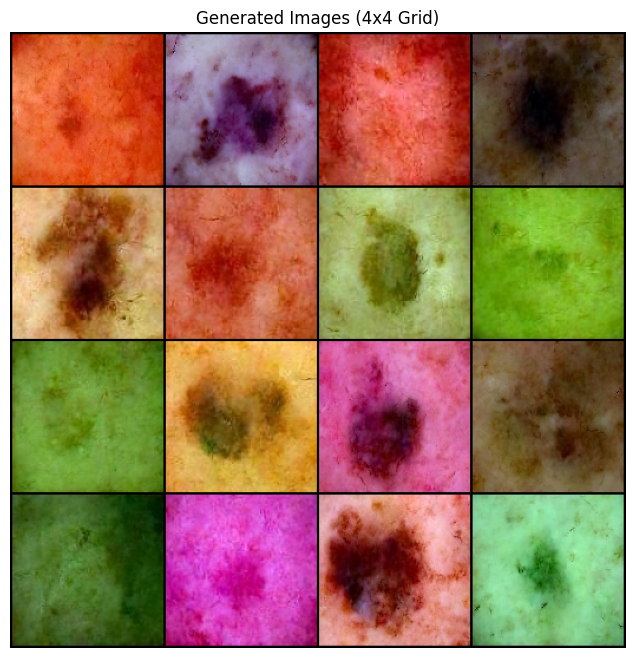

In [ ]:
# ================================
# Generate 16 Sample Images and Show in Grid
# ================================
import torch
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
from IPython.display import display

unet.eval()
n = 16  # number of images
sample = torch.randn(n, 3, IMG_SIZE, IMG_SIZE).to(device)

# Run the reverse diffusion process
for t in tqdm(reversed(range(scheduler.num_train_timesteps)), desc="Generating 16 samples"):
    with torch.no_grad():
        noise_pred = unet(sample, torch.tensor([t]*n, device=device)).sample
    sample = scheduler.step(noise_pred, t, sample).prev_sample

# Scale images from [-1, 1] → [0, 1]
sample = (sample + 1) / 2

# Create a 4x4 grid
grid = make_grid(sample, nrow=4)

# Save the grid image
save_image(grid, "outputs/diffusion/generated_16.png")

# Show in Colab
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.title("Generated Images (4x4 Grid)")
plt.show()


In [ ]:
import shutil

src_path = "/content/outputs/diffusion/best_model.pth"
dst_path = "/content/drive/MyDrive/skin_diffusion/checkpoints/best_model.pth"

shutil.copy(src_path, dst_path)
print(" Best model copied to Drive at:", dst_path)

 Best model copied to Drive at: /content/drive/MyDrive/skin_diffusion/checkpoints/best_model.pth


Using device: cuda


/usr/local/lib/python3.12/dist-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


 Loaded best model (Epoch 90 | Loss=0.0177)


Generating 16 samples: 1000it [04:23,  3.79it/s]


 Saved locally at: outputs/diffusion/best_grid_16.png
 Saved to Drive at: /content/drive/MyDrive/skin_diffusion/samples/best_grid_16.png


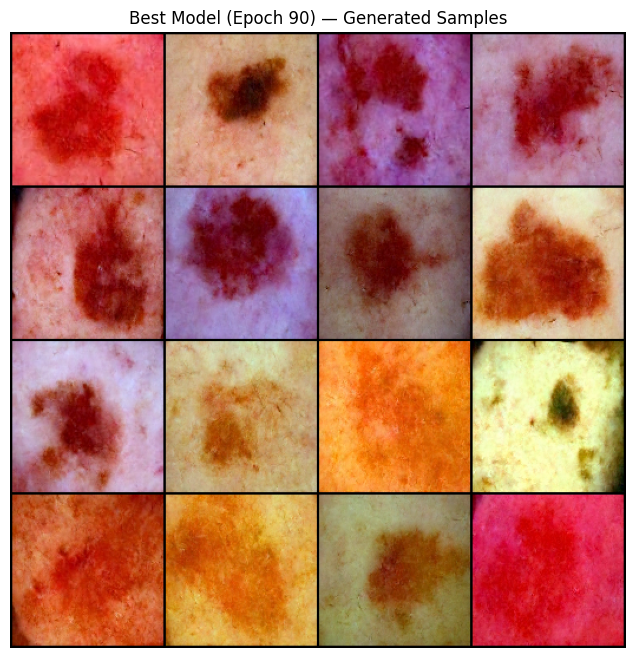

In [ ]:
import torch
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# --- GPU setup ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- Paths ---
DRIVE_ROOT = "/content/drive/MyDrive/skin_diffusion"
CHECKPOINTS_DIR = os.path.join(DRIVE_ROOT, "checkpoints")
SAMPLES_DIR     = os.path.join(DRIVE_ROOT, "samples")
os.makedirs(SAMPLES_DIR, exist_ok=True)

best_model_path = os.path.join(CHECKPOINTS_DIR, "best_model.pth")
best_grid_path_local = "outputs/diffusion/best_grid_16.png"
best_grid_path_drive = os.path.join(SAMPLES_DIR, "best_grid_16.png")

# --- Load best model ---
checkpoint = torch.load(best_model_path, map_location=device)
unet.load_state_dict(checkpoint["model_state_dict"])
unet.to(device)
unet.eval()

print(f" Loaded best model (Epoch {checkpoint['epoch']} | Loss={checkpoint['loss']:.4f})")

# --- Generate 16 samples ---
n = 16
sample = torch.randn(n, 3, IMG_SIZE, IMG_SIZE).to(device)

for t in tqdm(reversed(range(scheduler.num_train_timesteps)), desc="Generating 16 samples"):
    with torch.no_grad():
        noise_pred = unet(sample, torch.tensor([t] * n, device=device)).sample
    sample = scheduler.step(noise_pred, t, sample).prev_sample

# --- Scale [-1,1] → [0,1] ---
sample = (sample + 1) / 2

# --- Create 4x4 grid ---
grid = make_grid(sample, nrow=4)

# --- Save locally ---
os.makedirs("outputs/diffusion", exist_ok=True)
save_image(grid, best_grid_path_local)
print(f" Saved locally at: {best_grid_path_local}")

# --- Save to Drive ---
save_image(grid, best_grid_path_drive)
print(f" Saved to Drive at: {best_grid_path_drive}")

# --- Display in Colab ---
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.title(f"Best Model (Epoch {checkpoint['epoch']}) — Generated Samples")
plt.show()

In [ ]:
!pip install clean-fid

Fake Images Generation

In [ ]:
import os
from torchvision.utils import save_image
from tqdm import tqdm

os.makedirs("outputs/fake_images", exist_ok=True)

n = 100  # number of fake images to generate
unet.eval()

for i in tqdm(range(n), desc="Generating fake images for FID"):
    sample = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
    for t in reversed(range(scheduler.num_train_timesteps)):
        with torch.no_grad():
            noise_pred = unet(sample, torch.tensor([t]*sample.size(0), device=device)).sample
        sample = scheduler.step(noise_pred, t, sample).prev_sample
    save_image((sample + 1) / 2, f"outputs/fake_images/{i:04d}.png")

Generating fake images for FID: 100%|██████████| 100/100 [41:36<00:00, 24.96s/it]


Real Images Generation

In [ ]:
import os
import random
from torchvision.utils import save_image

os.makedirs("outputs/real_images", exist_ok=True)

# If dataset is a Subset, use its underlying dataset and indices correctly
if isinstance(dataset, torch.utils.data.Subset):
    base_dataset = dataset.dataset
    indices = dataset.indices
else:
    base_dataset = dataset
    indices = range(len(dataset))

# Randomly sample up to 500 images (or all if fewer)
num_real = min(500, len(indices))
real_imgs = random.sample(indices, num_real)

for i, idx in enumerate(real_imgs):
    img = base_dataset[idx]
    save_image((img + 1) / 2, f"outputs/real_images/{i:04d}.png")

print(f"Saved {num_real} real images to outputs/real_images/")

Saved 500 real images to outputs/real_images/


FID Score

In [ ]:
from cleanfid import fid

score = fid.compute_fid(
    "outputs/real_images",
    "outputs/fake_images"
)

print(f"FID Score: {score:.2f}")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


compute FID between two folders
Found 500 images in the folder outputs/real_images


FID real_images : 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


Found 100 images in the folder outputs/fake_images


FID fake_images : 100%|██████████| 4/4 [00:06<00:00,  1.66s/it]


FID Score: 203.44


In [ ]:
# =====================================
# Compute Max-SSIM (each fake vs. all reals)
# =====================================
from skimage.metrics import structural_similarity as ssim
import numpy as np
from PIL import Image
from tqdm import tqdm
import os

# Paths to your folders
real_path = "outputs/real_images"
fake_path = "outputs/fake_images"

# Load all real and fake images
real_files = sorted([os.path.join(real_path, f) for f in os.listdir(real_path) if f.endswith(('.png', '.jpg'))])
fake_files = sorted([os.path.join(fake_path, f) for f in os.listdir(fake_path) if f.endswith(('.png', '.jpg'))])

# Resize and normalize all real images once
real_images = []
for rf in tqdm(real_files, desc="Loading real images"):
    r_img = np.array(Image.open(rf).resize((128, 128))).astype(np.float32) / 255.0
    r_img = np.mean(r_img, axis=2)  # grayscale
    real_images.append(r_img)

def max_ssim(fake_img, real_images):
    max_score = 0
    for r in real_images:
        score = ssim(fake_img, r, data_range=1.0)
        max_score = max(max_score, score)
    return max_score

max_ssim_scores = []
for ff in tqdm(fake_files, desc="Computing max ssim"):
    f_img = np.array(Image.open(ff).resize((128, 128))).astype(np.float32) / 255.0
    f_img = np.mean(f_img, axis=2)
    max_score = max_ssim(f_img, real_images)
    max_ssim_scores.append(max_score)

# Average score
avg_max_ssim = np.mean(max_ssim_scores)
print(f"\nAverage SSIM: {avg_max_ssim:.4f}")

Computing max ssim: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Average SSIM: 0.4537


In [ ]:
!pip install lpips
!pip install torch torchvision pillow tqdm

import torch
import lpips
from PIL import Image
import numpy as np
import os
from tqdm import tqdm
import torchvision.transforms as T

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lpips_model = lpips.LPIPS(net='vgg').to(device)

# Paths
real_path = "outputs/real_images"
fake_path = "outputs/fake_images"

# Transform (normalize to [-1,1] and resize)
transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Load image paths
real_files = sorted([os.path.join(real_path, f) for f in os.listdir(real_path) if f.endswith(('.png', '.jpg'))])
fake_files = sorted([os.path.join(fake_path, f) for f in os.listdir(fake_path) if f.endswith(('.png', '.jpg'))])

n = min(len(real_files), len(fake_files))
real_files, fake_files = real_files[:n], fake_files[:n]
print(f"Comparing {n} pairs of images...")

lpips_scores = []
for r_path, f_path in tqdm(zip(real_files, fake_files), total=n):
    img_r = transform(Image.open(r_path).convert("RGB")).unsqueeze(0).to(device)
    img_f = transform(Image.open(f_path).convert("RGB")).unsqueeze(0).to(device)

    with torch.no_grad():
        score = lpips_model(img_r, img_f).item()
    lpips_scores.append(score)

avg_lpips = np.mean(lpips_scores)
print(f"\nAverage Lpips: {avg_lpips:.4f}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.6 MB/s eta 0:00:00
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:06<00:00, 89.0MB/s]


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/vgg.pth
Comparing 100 pairs of images...


100%|██████████| 100/100 [00:01<00:00, 93.85it/s]


Average Lpips: 0.7434


In [ ]:
!pip install torch-fidelity

from torch_fidelity import calculate_metrics

real_path = "/content/outputs/real_images"  # your original images folder
fake_path = "outputs/fake_images" # Corrected path

metrics = calculate_metrics(
    input1=real_path,
    input2=fake_path,
    cuda=False,
    isc=True,      # Inception Score
    kid=False,
    verbose=True
)

print("Inception Score:", metrics['inception_score_mean'], "±", metrics['inception_score_std'])

Creating feature extractor "inception-v3-compat" with features ['logits_unbiased']
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:02<00:00, 36.2MB/s]
Extracting features from input1
Looking for samples non-recursivelty in "/content/outputs/real_images" with extensions png,jpg,jpeg
Found 500 samples
/usr/local/lib/python3.12/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/data

Inception Score: 3.9256332114137664 ± 0.3851753248472551


Processing samples
Inception Score: 3.9256332114137664 ± 0.3851753248472551


In [ ]:
import os

save_path = '/content/drive/MyDrive/synthetic_outputs/diffusion'
os.makedirs(save_path, exist_ok=True)

In [ ]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image

# --- Safety defaults in case vars are missing ---
if "epoch_losses" not in locals():
    epoch_losses = []
if "best_epoch" not in locals():
    best_epoch = None
if "best_loss" not in locals():
    best_loss = None
if "best_model_state_dict" not in locals():
    best_model_state_dict = unet.state_dict()
if "best_optimizer_state_dict" not in locals():
    best_optimizer_state_dict = optimizer.state_dict()

# --- 1️⃣ Save Final Model ---
model_path = os.path.join(CHECKPOINTS_DIR, "final_model.pth")
torch.save({
    "model_state_dict": unet.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "epoch_losses": epoch_losses,
}, model_path)
print(f" Final model saved at: {model_path}")

# --- 2️⃣ Save Best Model ---
best_model_path = os.path.join(CHECKPOINTS_DIR, f"best_model_epoch_{best_epoch or 'last'}.pth")
torch.save({
    "epoch": best_epoch,
    "best_loss": best_loss,
    "model_state_dict": best_model_state_dict,
    "optimizer_state_dict": best_optimizer_state_dict,
}, best_model_path)
print(f" Best model saved at: {best_model_path}")

# --- 3️⃣ Save Metrics CSV ---
if epoch_losses:
    metrics_df = pd.DataFrame({
        "epoch": list(range(1, len(epoch_losses)+1)),
        "train_loss": epoch_losses
    })
    metrics_csv = os.path.join(METRICS_DIR, "train_metrics.csv")
    metrics_df.to_csv(metrics_csv, index=False)
    print(f" Metrics saved to: {metrics_csv}")
else:
    print(" No epoch losses found — skipping metrics save.")

# --- 4️⃣ Plot Loss Curve ---
if epoch_losses:
    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(epoch_losses)+1), epoch_losses, color="teal", marker="o", linewidth=2)
    plt.title("Diffusion Model - Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.grid(True)
    plt.tight_layout()

    plot_path = os.path.join(PLOTS_DIR, "loss_curve.png")
    plt.savefig(plot_path)
    plt.show()
    print(f" Loss curve saved to: {plot_path}")
else:
    print(" Skipping plot — no epoch loss data available.")

# --- 5️⃣ Generate and Save Final Samples ---
unet.eval()
num_samples = 16
samples = torch.randn(num_samples, 3, IMG_SIZE, IMG_SIZE).to(device)

for t in reversed(range(scheduler.num_train_timesteps)):
    with torch.no_grad():
        model_output = unet(samples, torch.tensor([t], device=device)).sample
        samples = scheduler.step(model_output, t, samples).prev_sample

samples = (samples.clamp(-1, 1) + 1) / 2
grid = make_grid(samples, nrow=4)
sample_path = os.path.join(SAMPLES_DIR, "final_samples.png")
save_image(grid, sample_path)
print(f" Generated sample grid saved to: {sample_path}")

# --- 6️⃣ Placeholder Metrics File ---
metrics_summary = {
    "FID": None,
    "SSIM": None,
    "LPIPS": None,
    "Inception": None
}
pd.DataFrame([metrics_summary]).to_csv(os.path.join(METRICS_DIR, "final_metrics.csv"), index=False)
print(" Placeholder metrics file saved (fill in after computing).")

print("\n All results saved to Google Drive → /MyDrive/skin_diffusion/")

 Final model saved at: /content/drive/MyDrive/skin_diffusion/checkpoints/final_model.pth
 Best model saved at: /content/drive/MyDrive/skin_diffusion/checkpoints/best_model_epoch_90.pth
 No epoch losses found — skipping metrics save.
 Skipping plot — no epoch loss data available.


/usr/local/lib/python3.12/dist-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


 Generated sample grid saved to: /content/drive/MyDrive/skin_diffusion/samples/final_samples.png
 Placeholder metrics file saved (fill in after computing).

 All results saved to Google Drive → /MyDrive/skin_diffusion/


In [ ]:
import torch
import os
from torchvision import transforms
from torchvision.utils import make_grid, save_image
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import numpy as np
import pandas as pd

# =========================
# CONFIG
# =========================
best_model_path = os.path.join(CHECKPOINTS_DIR, f"best_model_epoch_{best_epoch}.pth")
generated_path = os.path.join(SAMPLES_DIR, f"best_epoch_{best_epoch}_samples.png")
real_images_dir = "/content/outputs/real_images"

# =========================
# LOAD BEST MODEL
# =========================
checkpoint = torch.load(best_model_path, map_location=device)
unet.load_state_dict(checkpoint["model_state_dict"])
unet.to(device)
unet.eval()
print(f" Loaded best model from {best_model_path}")

# =========================
# COMPUTE SSIM
# =========================

# Convert tensor samples to NumPy images
generated_imgs = samples.detach().cpu()

# Transform for comparison (same size, 0–255 scale)
to_pil = transforms.ToPILImage()
to_tensor = transforms.ToTensor()

real_imgs = []
for file in os.listdir(real_images_dir)[:num_samples]:
    img = Image.open(os.path.join(real_images_dir, file)).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    real_imgs.append(to_tensor(img))
real_imgs = torch.stack(real_imgs)

# Compute mean SSIM across pairs
ssim_scores = []
for gen, real in zip(generated_imgs, real_imgs):
    gen_np = np.transpose(gen.numpy(), (1, 2, 0))
    real_np = np.transpose(real.numpy(), (1, 2, 0))
    ssim_val = ssim(gen_np, real_np, channel_axis=2, data_range=1.0)
    ssim_scores.append(ssim_val)

mean_ssim = np.mean(ssim_scores)
print(f" Mean SSIM for best epoch ({best_epoch}): {mean_ssim:.4f}")

# =========================
# SAVE TO METRICS CSV
# =========================
metrics_csv = os.path.join(METRICS_DIR, "final_metrics.csv")

if os.path.exists(metrics_csv):
    df = pd.read_csv(metrics_csv)
    df.loc[0, "SSIM"] = mean_ssim
else:
    df = pd.DataFrame([{"FID": None, "SSIM": mean_ssim, "LPIPS": None, "Inception": None}])

df.to_csv(metrics_csv, index=False)
print(f" SSIM score saved to {metrics_csv}")

 Loaded best model from /content/drive/MyDrive/skin_diffusion/checkpoints/best_model_epoch_90.pth
 Mean SSIM for best epoch (90): 0.2786
 SSIM score saved to /content/drive/MyDrive/skin_diffusion/metrics/final_metrics.csv


In [ ]:
import torch
import os
from torchvision import transforms
from PIL import Image
from pytorch_msssim import ms_ssim
import numpy as np
import pandas as pd

# Install if needed
# !pip install pytorch-msssim

# --- CONFIG ---
real_images_dir = "/content/outputs/real_images"
num_samples = 16
# Define the target size for MS-SSIM computation
msssim_size = 256 # Image size must be larger than 160 for MS-SSIM

# --- Prepare real and generated images ---
to_tensor = transforms.ToTensor()
real_imgs, gen_imgs = [], []

# Resize transform for MS-SSIM
resize_transform = transforms.Compose([
    transforms.Resize((msssim_size, msssim_size)),
    transforms.ToTensor()
])


for file in os.listdir(real_images_dir)[:num_samples]:
    img = Image.open(os.path.join(real_images_dir, file)).convert("RGB")
    # Apply resize transform
    real_imgs.append(resize_transform(img))


# 'samples' tensor = your generated images, scaled to [0,1]
# Apply resize transform to generated images
gen_imgs_resized = []
for img_tensor in samples.detach().cpu().clamp(0,1):
    img_pil = transforms.ToPILImage()(img_tensor)
    gen_imgs_resized.append(resize_transform(img_pil))

real_imgs = torch.stack(real_imgs)
gen_imgs = torch.stack(gen_imgs_resized)


# --- Compute MS-SSIM ---
ms_ssim_score = ms_ssim(gen_imgs, real_imgs, data_range=1.0, size_average=True).item()
print(f"Mean MS-SSIM for best epoch ({best_epoch}): {ms_ssim_score:.4f}")

# --- Save to CSV ---
metrics_csv = os.path.join(METRICS_DIR, "final_metrics.csv")
if os.path.exists(metrics_csv):
    df = pd.read_csv(metrics_csv)
else:
    df = pd.DataFrame([{"MS_SSIM": ms_ssim_score}])
df.loc[0, "MS_SSIM"] = ms_ssim_score
df.to_csv(metrics_csv, index=False)
print(f" MS-SSIM saved to {metrics_csv}")

Mean MS-SSIM for best epoch (90): 0.3326
 MS-SSIM saved to /content/drive/MyDrive/skin_diffusion/metrics/final_metrics.csv


In [ ]:
!pip install pytorch-msssim

In [ ]:
# ============================================
# LPIPS (Perceptual Similarity) for Best Model
# ============================================
import torch
import os
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
from tqdm import tqdm
import lpips  # install with: pip install lpips
import numpy as np
import pandas as pd

# =========================
# CONFIG
# =========================
best_model_path = os.path.join(CHECKPOINTS_DIR, f"best_model_epoch_{best_epoch}.pth")
real_images_dir = "/content/outputs/real_images"
fake_images_dir = "/content/outputs/fake_images"
os.makedirs(fake_images_dir, exist_ok=True)

# =========================
# LOAD BEST MODEL
# =========================
checkpoint = torch.load(best_model_path, map_location=device)
unet.load_state_dict(checkpoint["model_state_dict"])
unet.to(device)
unet.eval()
print(f" Loaded best model from {best_model_path}")

# =========================
# LOAD REAL AND FAKE IMAGES
# =========================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

real_imgs, fake_imgs = [], []
real_files = sorted(os.listdir(real_images_dir))[:num_samples]
fake_files = sorted(os.listdir(fake_images_dir))[:num_samples]

for rf, ff in zip(real_files, fake_files):
    rimg = transform(Image.open(os.path.join(real_images_dir, rf)).convert("RGB"))
    fimg = transform(Image.open(os.path.join(fake_images_dir, ff)).convert("RGB"))
    real_imgs.append(rimg)
    fake_imgs.append(fimg)

real_imgs = torch.stack(real_imgs)
fake_imgs = torch.stack(fake_imgs)

# =========================
# COMPUTE LPIPS
# =========================
loss_fn_alex = lpips.LPIPS(net='alex').to(device)
lpips_scores = []

for gen, real in tqdm(zip(fake_imgs, real_imgs), total=num_samples, desc="Computing LPIPS"):
    gen = gen.unsqueeze(0).to(device)
    real = real.unsqueeze(0).to(device)
    lp = loss_fn_alex(gen, real).item()
    lpips_scores.append(lp)

mean_lpips = np.mean(lpips_scores)
print(f" Mean LPIPS for best epoch ({best_epoch}): {mean_lpips:.4f}")

# =========================
# SAVE TO METRICS CSV
# =========================
metrics_csv = os.path.join(METRICS_DIR, "final_metrics.csv")

if os.path.exists(metrics_csv):
    df = pd.read_csv(metrics_csv)
else:
    df = pd.DataFrame([{"FID": None, "SSIM": None, "LPIPS": None, "Inception": None}])

df.loc[0, "LPIPS"] = mean_lpips
df.to_csv(metrics_csv, index=False)

print(f" LPIPS score saved to: {metrics_csv}")

 Loaded best model from /content/drive/MyDrive/skin_diffusion/checkpoints/best_model_epoch_90.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:03<00:00, 64.7MB/s]


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth


Computing LPIPS: 100%|██████████| 16/16 [00:00<00:00, 146.10it/s]

 Mean LPIPS for best epoch (90): 0.5005
 LPIPS score saved to: /content/drive/MyDrive/skin_diffusion/metrics/final_metrics.csv


In [ ]:
from PIL import Image
import numpy as np
import torch

# Example: generate 100 synthetic images and save them
for i in range(100):
    noise = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device) # Adjusted noise shape for UNet
    fake_img = unet(noise, torch.tensor([999], device=device)).sample # Use unet and a timestep
    fake_img = fake_img.detach().cpu().numpy().squeeze().transpose(1, 2, 0)

    # Normalize to 0–255 and convert to uint8
    fake_img = (fake_img - fake_img.min()) / (fake_img.max() - fake_img.min())
    fake_img = (fake_img * 255).astype(np.uint8)

    # Save to Drive
    Image.fromarray(fake_img).save(f'{save_path}/generated_{i:03d}.png')